In [1]:
import asf_search as asf
import earthaccess
import os
import numpy as np
from datetime import datetime

from src.opera_utils import read_opera_cslc
import matplotlib.pyplot as plt

import folium
from shapely.wkt import loads

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f'asf_search version: {asf.__version__}')

asf_search version: 7.1.3


In [3]:
def setup_asf_session():
    """
    Set up ASF session using earthaccess authentication
    Returns authenticated ASF Session object
    """
    # Authenticate using .netrc credentials
    auth = earthaccess.login()
    
    # Create ASF Session with direct netrc authentication
    session = asf.ASFSession()
    
    # Use netrc authentication
    session.auth_with_creds(auth.username, auth.password)
    return session

In [4]:
def search_opera_datasets(session, start_date, end_date, 
                aoi='POLYGON((-121.9658 45.6771,-121.9013 45.6771,-121.9013 45.7112,-121.9658 45.7112,-121.9658 45.6771))',
                dataset=asf.DATASET.OPERA_S1, processingLevel=asf.PRODUCT_TYPE.CSLC, operaBurstID=None):
    """
    Search for datasets based on given parameters
    
    Parameters:
    -----------
    session : ASFSession
        Authenticated ASF session
    start_date : str
        Start date in format 'YYYY-MM-DD'
    end_date : str
        End date in format 'YYYY-MM-DD'
    platform : str
        Satellite platform (default: 'SENTINEL-1A')
    beam_mode : str
        Beam mode (default: 'IW')
    processing_level : str
        Processing level (default: 'GRD_HD')
        
    Returns:
    --------
    list
        List of ASF Granule objects
    """
    # Convert dates to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    search_params = {
        'dataset': dataset,
        'processingLevel': processingLevel,
        'start': start,
        'end': end,
        'intersectsWith': aoi
    }

    if operaBurstID:
        search_params['operaBurstID'] = operaBurstID
    
    # Perform search
    results = asf.geo_search(**search_params)
    print(f"Found {len(results)} datasets matching criteria")
    return results

In [5]:
def download_datasets(session, results, output_dir):
    """
    Download datasets to specified directory
    
    Parameters:
    -----------
    session : ASFSession
        Authenticated ASF session
    results : list
        List of ASF Granule objects
    output_dir : str
        Directory to save downloaded files
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Download each dataset
    for i, result in enumerate(results, 1):
        print(f"Downloading dataset {i} of {len(results)}: {result.properties['fileName']}")
        result.download(path=output_dir, session=session)
        print(f"Successfully downloaded {result.properties['fileName']}")

In [6]:
# # Set up session using earthaccess
session = setup_asf_session()

# Example search parameters
start_date = '2022-01-01'
end_date = '2022-01-18'
output_dir = 'asf_downloads'

In [7]:
# Search for datasets
results = search_opera_datasets(session, 
                        start_date=start_date,
                        end_date=end_date,
                        operaBurstID='T115_245667_IW3',
                        aoi='POLYGON((-121.9658 45.6771,-121.9013 45.6771,-121.9013 45.7112,-121.9658 45.7112,-121.9658 45.6771))')

# Download datasets if any found
if results:
    download_datasets(session, results, output_dir)
    print(f"All downloads completed. Files saved to {output_dir}")
else:
    print("No datasets found matching the criteria.")

Found 2 datasets matching criteria
Successfully downloaded OPERA_L2_CSLC-S1_T115-245667-IW3_20220116T141417Z_20240731T102853Z_S1A_VV_v1.1.h5
Successfully downloaded OPERA_L2_CSLC-S1_T115-245667-IW3_20220104T141418Z_20240731T072052Z_S1A_VV_v1.1.h5
All downloads completed. Files saved to asf_downloads


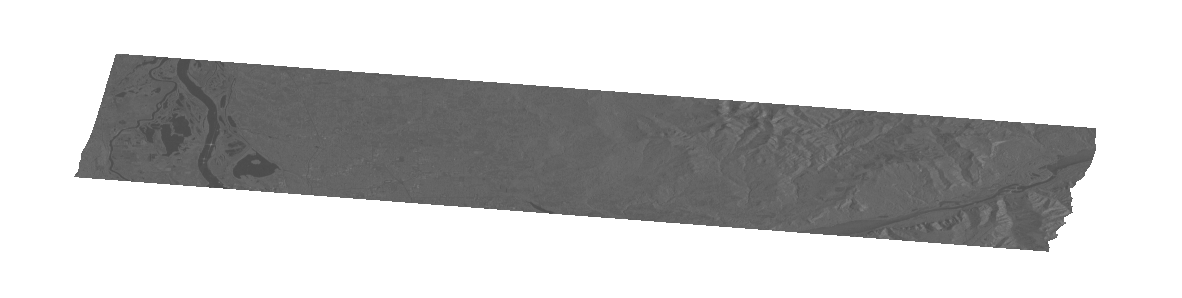

In [8]:
fname = f"{output_dir}/{results[0].properties['fileName']}"

cslc, params = read_opera_cslc(fname)

fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(np.abs(cslc)**0.1, cmap='gray')
ax.axis('off')
plt.show()

In [9]:
def plot_polygon_on_map(polygon_str: str, center_lat: float = None, center_lon: float = None) -> folium.Map:
    """
    Plot a WKT polygon string on a folium map with switchable base layers.
    
    Args:
        polygon_str (str): WKT polygon string in format 'POLYGON((...))'
        center_lat (float, optional): Center latitude for map. If None, calculated from polygon
        center_lon (float, optional): Center longitude for map. If None, calculated from polygon
        
    Returns:
        folium.Map: Map with polygon overlay and layer control
    """
    # Convert WKT string to shapely polygon
    polygon = loads(polygon_str)
    
    # Extract coordinates
    coords = list(polygon.exterior.coords)
    
    # Convert to list of [lat, lon] for folium
    folium_coords = [[lat, lon] for lon, lat in coords]
    
    # Calculate center if not provided
    if center_lat is None or center_lon is None:
        center_lat = np.mean([coord[0] for coord in folium_coords])
        center_lon = np.mean([coord[1] for coord in folium_coords])
    
    # Create empty base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=10,
        control_scale=True,
        tiles=None
    )
    
    # Add ESRI Satellite as default base layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='ESRI Satellite',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Add OpenStreetMap as additional layer
    folium.TileLayer(
        tiles='OpenStreetMap',
        name='OpenStreetMap',
        overlay=False,
        control=True,
        show=False
    ).add_to(m)
    
    # Add polygon to map
    folium.Polygon(
        locations=folium_coords,
        color='red',
        weight=2,
        fill=True,
        fill_color='red',
        fill_opacity=0.2,
        popup='CSLC Coverage',
        name='CSLC Coverage'
    ).add_to(m)
    
    # Add layer control
    folium.LayerControl(position='topright').add_to(m)
    
    return m

In [10]:
polygon_str = params['bounding_polygon']
center_lat = params['center_lat']
center_lon = params['center_lon']

m = plot_polygon_on_map(polygon_str, center_lat, center_lon)

display(m)